In [1]:
'''
如果您已经有了一个包含5万个坐标点的二维数组coords，并希望在这个分布上采样5万个新的坐标点，可以使用numpy.random.multivariate_normal()函数来进行采样。具体步骤如下：

计算坐标点的协方差矩阵：cov = np.cov(coords.T)

使用numpy.random.multivariate_normal()函数生成符合多元正态分布的坐标点：new_coords = np.random.multivariate_normal(np.mean(coords, axis=0), cov, size=50000)

完整代码如下：

import numpy as np

# 假设coords是已知分布的5万个坐标点
coords = np.random.randn(50000, 2)

# 计算坐标点的协方差矩阵
cov = np.cov(coords.T)

# 生成符合多元正态分布的新坐标点
new_coords = np.random.multivariate_normal(np.mean(coords, axis=0), cov, size=50000)
这段代码会生成一个包含5万个坐标点的二维数组new_coords，其中每个坐标点都符合与coords相同的分布。这里使用的是坐标点的协方差矩阵来生成多元正态分布的坐标点，因此生成的坐标点的分布情况与原始坐标点的分布情况类似。
'''

'\n如果您已经有了一个包含5万个坐标点的二维数组coords，并希望在这个分布上采样5万个新的坐标点，可以使用numpy.random.multivariate_normal()函数来进行采样。具体步骤如下：\n\n计算坐标点的协方差矩阵：cov = np.cov(coords.T)\n\n使用numpy.random.multivariate_normal()函数生成符合多元正态分布的坐标点：new_coords = np.random.multivariate_normal(np.mean(coords, axis=0), cov, size=50000)\n\n完整代码如下：\n\nimport numpy as np\n\n# 假设coords是已知分布的5万个坐标点\ncoords = np.random.randn(50000, 2)\n\n# 计算坐标点的协方差矩阵\ncov = np.cov(coords.T)\n\n# 生成符合多元正态分布的新坐标点\nnew_coords = np.random.multivariate_normal(np.mean(coords, axis=0), cov, size=50000)\n这段代码会生成一个包含5万个坐标点的二维数组new_coords，其中每个坐标点都符合与coords相同的分布。这里使用的是坐标点的协方差矩阵来生成多元正态分布的坐标点，因此生成的坐标点的分布情况与原始坐标点的分布情况类似。\n'

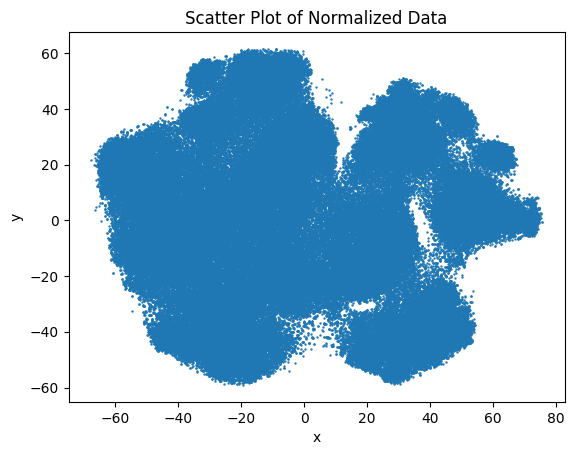

In [2]:
import numpy as np
from scipy.stats import norm
import torch
# 读取二维坐标数据
kdTree = torch.load("./static/data/CIFAR10/2D_kdTree/2D_kdTree_200000.pt")
coords = kdTree.data
import matplotlib.pyplot as plt
plt.scatter(coords[:, 0], coords[:, 1], s=0.5)
# 添加坐标轴标签和图标题
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Normalized Data')
plt.show()

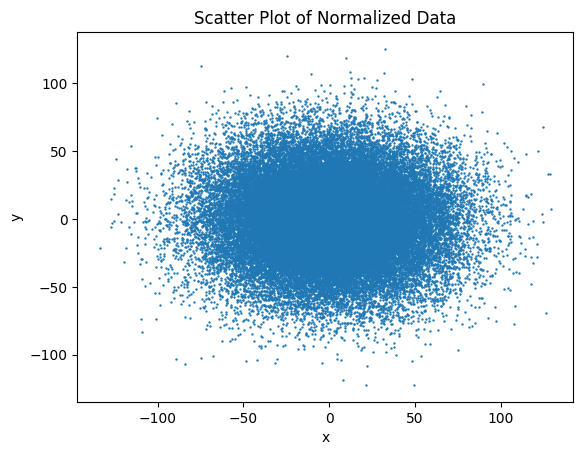

In [3]:
import numpy as np

# 计算坐标点的协方差矩阵
cov = np.cov(coords.T)

# 生成符合多元正态分布的新坐标点
new_coords = np.random.multivariate_normal(np.mean(coords, axis=0), cov, size=50000)
plt.scatter(new_coords[:, 0], new_coords[:, 1], s=0.5)
# 添加坐标轴标签和图标题
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Normalized Data')
plt.show()


In [4]:
latent_z_path="./static/data/CIFAR10/latent_z/BigGAN_208z_200000.pt"
latent_z = torch.load(latent_z_path, map_location="cpu") #因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错

In [5]:
from scipy import spatial
norm_tree =  spatial.KDTree(data=new_coords)

In [6]:
def get_zs_prevent_stick(coordinates, kdTree_2D, latent_z, k=10):
    '''
    nearest_distance: n*k维
    nearest_index: n*k维
    dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
    '''
    print("进入了防止粘在一块~~~~~~~~~~~~~~~~~~")
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for i, pos in enumerate(coordinates): #对每一个坐标进行插值
        # pos坐标对应的近邻下标
        pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
        pos_nearst_distance = nearest_distance[i]

        # 最近邻的坐标点，以及最近的距离
        most_nearst_pos = origin_coordinates[pos_nearst_index[0]]
        most_nearst_dis = pos_nearst_distance[0]

        # 利用三角形,找到第二个插值基点，让两边之和越接近第三边，就越是钝角，就越合理
        s1 = most_nearst_dis
        best_index = 1 # 默认第二个最近邻最好
        min_dif = 100
        for j in range(1, k):
            cur_pos = origin_coordinates[pos_nearst_index[j]]
            s2 = pos_nearst_distance[j]
            s3 = np.linalg.norm(most_nearst_pos-cur_pos)
            if (s1 + s2) - s3 < min_dif: # 两边之和大于等于第三边，所以不用绝对值
                min_dif = (s1 + s2) - s3
                best_index = j
        
        temp_z_0 = latent_z[pos_nearst_index[0]].clone().detach()
        temp_z_1 = latent_z[pos_nearst_index[best_index]].clone().detach()
        sum_distance = most_nearst_dis + pos_nearst_distance[best_index]
        z_new = (sum_distance-most_nearst_dis)/(sum_distance) * temp_z_0 + (sum_distance-pos_nearst_distance[best_index])/(sum_distance) * temp_z_1

        z_new = z_new.unsqueeze(0)
        if i == 0:
            zs = z_new
        else:
            zs = torch.cat((zs, z_new), dim=0)

    return zs

In [7]:
zs = get_zs_prevent_stick(new_coords, kdTree, latent_z)

进入了防止粘在一块~~~~~~~~~~~~~~~~~~


In [8]:
print(zs.shape)

torch.Size([50000, 208])


In [9]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# 用来处理zs的类，方便使用batchsize
class Mydata_sets(Dataset):
    
    def __init__(self, zs):
        super(Mydata_sets, self).__init__()
        self.zs = zs

    def __getitem__(self, index):
        z = self.zs[index]
        return z

    def __len__(self):
        return len(self.zs)

In [10]:
zs_datasets = Mydata_sets(zs)
zs_loader = DataLoader(zs_datasets, batch_size=200, shuffle=False, num_workers=1)

In [11]:
model_files_dir = "./model_files/" # 模型位置
sys.path.append(model_files_dir)
import model_files as model_all
checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=162000.pth"
device = torch.device("cuda:0")
G = model_all.get_generative_model("CIFAR10").to(device)
G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
G.eval()
print()

In [12]:
import torchvision.transforms as transforms
import torchvision.utils as utils

transform = transforms.Compose(
        [
            transforms.Normalize([0.4914,0.4822,0.4465], [0.2023,0.1994,0.2010])
        ]
    )

first = 0 # 判断是否第一次进入循环
count = 0
with torch.no_grad(): # 取消梯度计算，加快运行速度
    for batch_z in zs_loader: 
        z = torch.tensor(batch_z).to(torch.float32).to(device)    # latent code
        imgs = G(z)   
        for i, img in enumerate(imgs):
            img = ((img + 1)/2).clamp(0.0, 1.0) # 变换到[0,1]范围内
            utils.save_image(img.detach().cpu(), f'./临时垃圾-随时可删/sample2D_50k/pic{count}.jpg')
            count += 1



/home/kuangjielong/.conda/envs/python3_7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [13]:
import sys
python_files_dir = "./python_files/" # python工具包位置
sys.path.append(python_files_dir)
import fid_score as official_fid
# fid计算模型
dims = 2048
batch_size = 1
num_avail_cpus = len(os.sched_getaffinity(0))
num_workers = min(num_avail_cpus, 8)
block_idx = official_fid.InceptionV3.BLOCK_INDEX_BY_DIM[2048]
fid_model = official_fid.InceptionV3([block_idx]).to(device)
print('fid_model load success!')


pic_path_fid1 = './临时垃圾-随时可删/sample2D_50k/'
pic_path_fid2 = './static/data/CIFAR10/pic/random_50k'
    
batch_size = 100
m1, s1 = official_fid.compute_statistics_of_path(pic_path_fid1, fid_model, batch_size,
                                    dims, device, num_workers)
m2, s2 = official_fid.compute_statistics_of_path(pic_path_fid2, fid_model, batch_size,
                                    dims, device, num_workers)
fid_value=official_fid.calculate_frechet_distance(m1,s1,m2,s2) 
print(fid_value)

fid_model load success!


100%|██████████| 500/500 [00:51<00:00,  9.74it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
9.140014414413372
